In [1]:
import numpy as np 
import pandas as pd # Data Processing 
from sklearn.model_selection import train_test_split # Categorize trainset, validation set 

import torch
import torch.nn as nn 
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset 
import torch.onnx   
from torch.optim.lr_scheduler import ReduceLROnPlateau

import glob # File to list
from tqdm import tqdm # Process bar 

import matplotlib.pyplot as plt

In [2]:
class MinMaxScalingLayer(nn.Module):
    def __init__(self, min_features, max_features):
        super(MinMaxScalingLayer, self).__init__()
        self.register_buffer('min_features', torch.tensor(min_features, dtype=torch.float32))
        self.register_buffer('max_features', torch.tensor(max_features, dtype=torch.float32))

    def forward(self, x):
        return (x - self.min_features) / (self.max_features - self.min_features)  

class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ResidualBlock, self).__init__()

        self.hidden1 = nn.Linear(hidden_dim, hidden_dim) 
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.glu = nn.GLU() # Gated Linear Unit splits feature into half >> ex 128 to 64.

        self.hidden3 = nn.Linear(hidden_dim//2, hidden_dim)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.01)

        self.hidden4 = nn.Linear(hidden_dim, hidden_dim) 
        self.glu2 = nn.GLU() # half

        self.hidden5 = nn.Linear(hidden_dim//2, input_dim) 
        self.leaky_relu5 = nn.LeakyReLU(negative_slope=0.01)

        # 32 x 64 / 128 x 64

    def forward(self, x):
        out = self.leaky_relu1(self.hidden1(x))
        out = self.glu(self.hidden2(out))
        out = self.leaky_relu3(self.hidden3(out))
        out = self.glu2(self.hidden4(out))
        out = self.leaky_relu5(self.hidden5(out))
        return out

class MovePredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, min_features, max_features): 
        super(MovePredictionModel, self).__init__()

        self.minmax = MinMaxScalingLayer(min_features, max_features)

        self.input_layer = nn.Linear(input_dim, hidden_dim)

        # Residual block
        self.residual_block = ResidualBlock(input_dim, hidden_dim)

        self.hidden_skiplayer = nn.Linear(input_dim, hidden_dim)
        self.leakyrelu_skiplayer = nn.LeakyReLU(negative_slope=0.01)

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        normalized_out = self.minmax(x)
        
        processed_input = self.input_layer(normalized_out)
        residual_out = self.residual_block(processed_input) # output tensor size: input_dim
        
        out = normalized_out + residual_out # 
        out = self.hidden_skiplayer(out)
        out = self.leakyrelu_skiplayer(out)
        out = self.output_layer(out)
        return out

In [3]:
INPUT_DIM = 9 # Linear vel + Linear acc + Angular vel + Angular acc + pos diff(vel*delta t) + rot diff(angvel * delta t) + bIsDrifting
HIDDEN_DIM = 128
OUTPUT_DIM = 3 # Pos diff x y  and rot diff z 
EPOCHS = 5000
BATCH_SIZE = 64 
LEARNING_RATE = 1e-3 # 스케쥴러 있으니 LR 좀 크게 설정

OUTPUT_FILENAME = 'model/test.pth'
DATA_PATH = 'data'

cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [4]:
# Read .csv files with pandas
folder_path = "data/"
csv_file_paths = glob.glob(f"{folder_path}/*.csv")

data_frames = [pd.read_csv(path) for path in csv_file_paths]
data = pd.concat(data_frames, ignore_index=True)
print(len(data))
# csv_file_paths = glob.glob(f'{DATA_PATH}/**/*.csv', recursive=True)
# for path in csv_file_paths:
#     print(path)

# Convert to tensor 
x_features_csv = [i for i in range(9)] # 0 - 8 idx
y_features_csv = [i for i in range(9, 12)] # 9 - 11 idx 

input_features = data.values[:,x_features_csv] # 0 - 8
output_features = data.values[:, y_features_csv]

X = torch.tensor(input_features, dtype=torch.float32)
y = torch.tensor(output_features, dtype=torch.float32)

print(y)
#print(X.shape, y.shape)

# Min max scaling
x_min_features, x_max_features = input_features.min(axis=0), input_features.max(axis=0)
y_min_features, y_max_features = output_features.min(axis=0), output_features.max(axis=0)

# Dataset split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# print(f'Training samples: {len(train_loader.dataset)}')
# print(f'Validation samples: {len(val_loader.dataset)}')

batch = next(iter(train_loader))  # 첫 번째 배치 가져오기
print(batch[0].shape) 


12767
tensor([[ 6.7012e+01,  2.9694e+01,  0.0000e+00],
        [ 7.6529e+01,  3.2894e+01, -5.2360e-02],
        [ 8.6817e+01,  3.4000e+01, -5.2360e-02],
        ...,
        [ 1.3340e+02, -1.8288e+02,  0.0000e+00],
        [ 1.1309e+02, -1.5504e+02,  0.0000e+00],
        [ 8.0898e+01, -1.1090e+02,  0.0000e+00]])
torch.Size([64, 9])


Epoch 1, Validation RMSE: 144.15283203125
New best model with RMSE: 144.15283203125, saving model...
Epoch 21, Validation RMSE: 15.108502388000488
New best model with RMSE: 15.108502388000488, saving model...
Epoch 41, Validation RMSE: 16.55499839782715
Validation RMSE did not improve. Patience counter: 1/20
Epoch 61, Validation RMSE: 15.392454147338867
Validation RMSE did not improve. Patience counter: 2/20
Epoch 81, Validation RMSE: 13.315435409545898
New best model with RMSE: 13.315435409545898, saving model...
Epoch 101, Validation RMSE: 11.951513290405273
New best model with RMSE: 11.951513290405273, saving model...
Epoch 121, Validation RMSE: 10.93747329711914
New best model with RMSE: 10.93747329711914, saving model...
Epoch 141, Validation RMSE: 11.405994415283203
Validation RMSE did not improve. Patience counter: 1/20
Epoch 161, Validation RMSE: 13.067773818969727
Validation RMSE did not improve. Patience counter: 2/20
Epoch 181, Validation RMSE: 14.235635757446289
Validation 

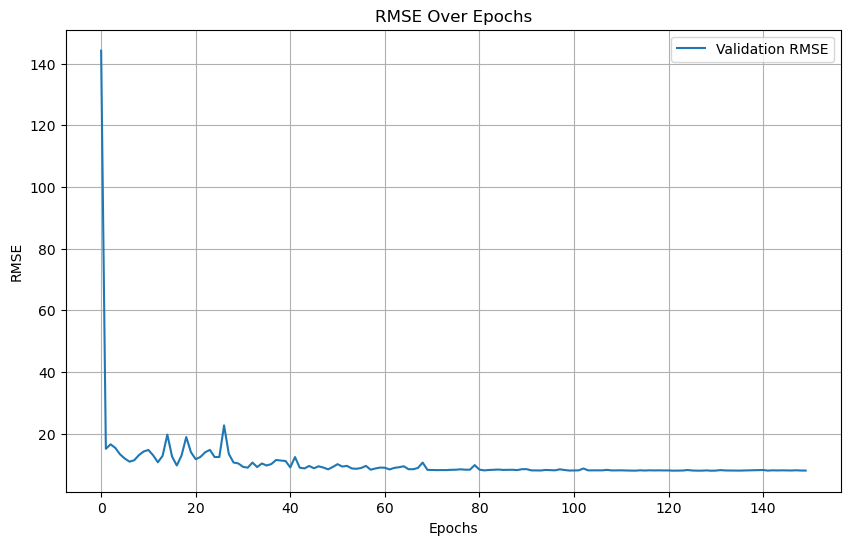

In [5]:
# Set model
model = MovePredictionModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, x_min_features, x_max_features)

if cuda_available:
    model.cuda()

epochs = EPOCHS
best_val_rmse = float('inf')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

# 스케줄러 추가
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min',      # epoch_val_rmse가 낮을수록 좋은 지표
    factor=0.5,      # LR을 1/2로 감소
    patience=10,     # 10 epoch 동안 개선 없으면 LR 감소
    threshold=1e-4,  # 개선 판단 임계값 (지표가 이 정도로 줄어들어야 개선으로 간주)
    cooldown=0, 
    min_lr=1e-7,     # LR이 너무 작아지는 것 방지
)

#loss_contributions = torch.tensor([1,1,1e+2]) # Rule of thumb maybe
y_std = y.std(dim=0)
if cuda_available:
    y_std = y_std.cuda()

# Early stopping 
patience = 20
es_counter = 0
early_stop = False

val_rmse_list = []

for epoch in range(epochs):
    # Tranining 
    model.train()
    #for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training"):
    for X_batch, y_batch in train_loader:
        if cuda_available:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        
        optimizer.zero_grad()

        y_pred = model(X_batch)

        loss = criterion(y_pred / y_std, y_batch / y_std)
        loss.backward()
        optimizer.step()

    if epoch % 20 == 0 or epoch == epochs-1:

        model.eval()

        val_rmse = []
        y_preds = []
        y_actuals = []
        with torch.no_grad():
            #for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} Validation"):
            for X_batch, y_batch in val_loader:

                ## if you have GPU
                if cuda_available:
                    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

                # inference the model
                y_pred = model(X_batch)

                # calculate RMSE
                rmse = torch.sqrt(criterion(y_pred, y_batch)).cpu().numpy()
                val_rmse.append(rmse)

                # for the first batch
                if len(y_preds) == 0:  
                    y_preds = y_pred.cpu().numpy()
                    y_actuals = y_batch.cpu().numpy()
                # for the rest of the batches
                else:  
                    y_preds = np.vstack((y_preds, y_pred.cpu().numpy()))
                    y_actuals = np.vstack((y_actuals, y_batch.cpu().numpy()))
        epoch_val_rmse = np.mean(val_rmse)
        val_rmse_list.append(epoch_val_rmse)

        print(f"Epoch {epoch+1}, Validation RMSE: {epoch_val_rmse}")
        
        # (중요) ReduceLROnPlateau는 step() 인자로 "검증 지표(loss)"를 넣어야 함
        # 여기서는 epoch_val_rmse 낮을수록 좋으므로 mode='min' 설정
        scheduler.step(epoch_val_rmse) 

        if epoch_val_rmse < best_val_rmse:
            best_val_rmse = epoch_val_rmse
            print(f"New best model with RMSE: {best_val_rmse}, saving model...")
            torch.save(model.state_dict(), OUTPUT_FILENAME)
            es_counter = 0
        else:
            es_counter += 1
            print(f"Validation RMSE did not improve. Patience counter: {es_counter}/{patience}")
            if es_counter >= patience:
                print("Early stopping triggered. End loop")
                early_stop = True
                break
    if early_stop:
        model.load_state_dict(torch.load(OUTPUT_FILENAME))
        break

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(range(len(val_rmse_list)), val_rmse_list, label='Validation RMSE')
plt.title('RMSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

In [6]:
ONNX_PATH = "model/KartPredictionModel_ver3.onnx"

model = MovePredictionModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, x_min_features, x_max_features)
model.load_state_dict(torch.load(OUTPUT_FILENAME))  
model.eval() 

dummy_input = torch.randn(1, INPUT_DIM) 

torch.onnx.export(
    model, 
    dummy_input, 
    ONNX_PATH, 
    verbose=True, 
    input_names=['input'], 
    output_names=['output'] 
    #dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)
